In [1]:
############# AT THE START, WE INSTALL PACKAGES WE NEED ###################################

# We use a package that might be new to some of you, called "INLA" 
# This package helps implement Bayesian methods and helps make some of our steps fast/easy to implement

############# OPEN R, THEN RUN THE FOLLOWING COMMAND ###################

# install.packages("INLA",repos=c(getOption("repos"),INLA="https://inla.r-inla-download.org/R/stable"), dep=TRUE)
# install.packages("fmesher", dependencies = TRUE)
# install.packages("MatrixModels", type = "source")
# install.packages("exactextractr")
# install.packages("sn" ,dependencies = TRUE)
# packages <- c("terra","dplyr","spdep", "exactextractr", "sf","ggplot2","viridis","sn","fmesher","exactextractr","fields")
# package.check <- lapply(packages, FUN = function(x) {
#     if (!require(x, character.only = TRUE)) {
#         install.packages(x, dependencies = TRUE)
#         library(x, character.only = TRUE, quietly=TRUE)
#     }
# })
# Sys.setenv("AWS_DEFAULT_REGION" = 'us-west-2')

# # ##### THE FOLLOWING COMMANDS ARE FOR THE INSTALLATION OF PACKAGES ON NASA MAAP #####
# # ##### CONDA-FORGE YOUR WAY THROUGH PACKAGES THAT DID NOT INSTALL ###################

# conda install conda-forge::r-fmesher
# conda install conda-forge::r-exactextractr
# conda install conda-forge::r-sn
# conda install conda-forge::r-inlabru
# conda install conda-forge::r-fields

In [22]:
########################################
############## LOAD PACKAGES ###########
########################################

# library("fmesher")
# library(MatrixModels)
# library(Matrix)
# library(INLA)
# library(inlabru)
# library("jpeg")
# library(gstat)
# library(MatrixModels)

library(sf)
library(terra)
library(dplyr)
library(spdep)
library(raster)
library(exactextractr)

library(ggplot2)
library(viridis)
library(stringr)
# library(sn)

source("/projects/ADE_biomass_harmonization/NASA_CMS/NASA_CMS_2023/Sudan/spde-book-functions.R")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:terra’:

    intersect, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: spData

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

Loading required package: sp


Attaching package: ‘raster’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: viridisLite



ERROR: Error in library(fields): there is no package called ‘fields’


In [ ]:
##########################################
######## CLEAN UP NFI VALUES ##############
##########################################

# library(sf)
# library(terra)

# nfi <- st_read("/projects/my-private-bucket/Data/NFI_data/Brazil/Brazil_NFI_dated.gpkg")
# all_subunits <- data.frame(
#   Subunidade = rep(1:4, each = length(unique(nfi$UA))),
#   UA = rep(unique(nfi$UA), times = 4)
# )

# nfi_full <- merge(all_subunits, nfi, by = c("UA", "Subunidade"), all.x = TRUE)

# missing_rows <- is.na(nfi_full$AGB_Mg.ha2)

# nfi_full[missing_rows, c("AGB_Mg.ha2", "AGB_Mg")] <- 0

# fill_missing_values <- function(x) {
#   ifelse(is.na(x), x[!is.na(x)][1], x)  # Take the first non-NA value in the vector
# }

# nfi_full$Biome <- ave(nfi_full$Biome, nfi_full$UA, FUN = fill_missing_values)
# nfi_full$State <- ave(nfi_full$State, nfi_full$UA, FUN = fill_missing_values)
# nfi_full$lon_pc <- ave(nfi_full$lon_pc, nfi_full$UA, FUN = fill_missing_values)
# nfi_full$lat_pc <- ave(nfi_full$lat_pc, nfi_full$UA, FUN = fill_missing_values)
# nfi_full$Date_of_measurement <- ave(nfi_full$Date_of_measurement, nfi_full$UA, FUN = fill_missing_values)

# nfi_full_sf <- st_as_sf(nfi_full, coords = c("lon_pc", "lat_pc"), crs = st_crs(nfi))
# st_write(nfi_full_sf, "/projects/my-private-bucket/Data/NFI_data/Brazil/Brazil_NFI_filled.gpkg")

In [ ]:
### READ GEDI TILES AND EXTRACT AGB VALUES

# nfi <- st_read("/projects/my-private-bucket/Data/NFI_data/Brazil/AOI_NFI_6933.gpkg")
# nfi <- nfi %>% group_by(UA) %>% summarise(mean = mean(AGB_Mg.ha2))
# nfi$AGB_Mg.ha2 <- nfi$mean
# colnames(nfi)

# FOLDER <- "/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID_GEDI"
# GEDI_FILES <- list.files(path = FOLDER, pattern = ("*.tif"), full.names = TRUE)
# GEDI_FILES <- GEDI_FILES[1:3]
# GEDI_FILES_DF <- as.data.frame(nfi$UA)
# for (each_GEDI in GEDI_FILES){
#     file.rast <- terra::project(rast(each_GEDI),"EPSG:6933")
#     file.plot = exactextractr::exact_extract(file.rast, st_buffer(nfi,100), 'mean')
#     GEDI_FILES_DF <- cbind(GEDI_FILES_DF,file.plot)
# }
# GEDI_FILES_DF <- GEDI_FILES_DF[,!grepl("standard_deviation", colnames(GEDI_FILES_DF))]
# GEDI_AGBD_PSU <- cbind(as.data.frame(nfi$UA),as.data.frame(rowMeans(GEDI_FILES_DF[,2:ncol(GEDI_FILES_DF)],na.rm=TRUE)))
# colnames(GEDI_AGBD_PSU) = c("PSU_ID","GEDI_AGB")
# # write.csv(GEDI_AGBD_PSU,"/projects/my-public-bucket/Data/NASA_CMS_2023/nfi/MNG/GEDI_files/GEDI_AGB_PSU.csv")


In [2]:
# library(INLA)
# library(Matrix)
# library(ggplot2)
# library(viridis)
# library(MatrixModels)

# #################################
# # Fitting a spatial-only coregionalization model. The model is
# #
    # # gedi(s) = int_gedi + A_1(s)w_1 + \epsilon_gedi(s)
    # # nfi(s) = int_nfi + \beta*A_1(s)w_1 + A_2(s)w_2 + \epsilon_nfi(s)

# #  where the int_gedi and int_nfi are intercepts, A_1(s) and A_2(s) are spatial effects, 
# #  w_1 and w_2 are weights for some of the spatial effects, and epsilon_gedi(s) 
# #  and epsilon_nfi(s) are uncorrelated error terms, with k=1,2,3k=1,2,3.

# # There are two SPDE Gaussian fields now, w_1 and w_2. 
# # The gedi and nfi are able to share information now because w_1 appears in both.
# # Notice that in the nfi equation, w_1 is scaled by coefficient \beta.
# # If \beta = 0, that means no relationship between gedi and nfi.
# # If the variance of \beta*w_1 is large relative to the variance of the remaining terms, A_1(s)w_2 + \epsilon_nfi(s),
# # that indicates a strong relationship between the two.
# # Assuming a good relationship, the dense gedi shots help us learn w_1 at a fine resolution,
# # which in turn helps us predict nfi.

# #################################



# #########################
# # Simulate data
# #########################

# This is a silly function I wrote to convert sigma/range pairs into INLA's internal parametrization.
# Only necessary for simulation, you can ignore.
# reg2theta = function(reg, nu = 1, alpha = 2){
#   sig = reg[1]
#   rho = reg[2]
#   log.kappa = log(8*nu)/2 - log(rho)
#   log.tau = 0.5*(lgamma(nu) - lgamma(alpha) - log(4*pi)) - log(sig) - nu*log.kappa
#   theta = c(log.tau, log.kappa)
#   return(theta)
# }

# n_nfi = 250
# n_gedi = 5e+3

# # parameters

# sigma1 = 1
# range1 = 0.075
# theta1 = reg2theta(c(sigma1, range1)) # INLA's internal parametrization
# tau1 = 0.5

# sigma2 = sqrt(0.25)
# range2 = 0.15
# theta2 = reg2theta(c(sigma2, range2)) # INLA's internal parametrization
# tau2 = 0.1

# beta = sqrt(0.75)
# intercept_gedi = 3
# intercept_nfi = 4

# # locs n meshes

# set.seed(96)

# loc_gedi = cbind(runif(n_gedi), runif(n_gedi))

# loc_nfi = cbind(runif(n_nfi), runif(n_nfi))

In [20]:
# AOI <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID/AOI.gpkg") %>% st_make_valid() %>% st_transform(crs=6933)
# st_write(AOI,"/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID/AOI_6933.gpkg")
# gedi <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID_GEDI/AOI_GEDI.gpkg") %>% st_transform(crs=6933)
# st_write(gedi,"/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID_GEDI/AOI_GEDI_6933.gpkg")
# nfi <- st_read("/projects/my-private-bucket/Data/NFI_data/Brazil/Brazil_NFI_filled.gpkg") %>% st_transform(crs=6933)
# nfi <- st_intersection(nfi,AOI)
# st_write(nfi,"/projects/my-private-bucket/Data/NFI_data/Brazil/AOI_NFI_6933.gpkg")

Reading layer `Brazil_NFI_filled' from data source 
  `/projects/my-private-bucket/Data/NFI_data/Brazil/Brazil_NFI_filled.gpkg' 
  using driver `GPKG'
Simple feature collection with 19752 features and 7 fields (with 3496 geometries empty)
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -73.0802 ymin: -24.11986 xmax: -37.80046 ymax: 4.139996
Geodetic CRS:  WGS 84


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


Writing layer `AOI_NFI_6933' to data source 
  `/projects/my-private-bucket/Data/NFI_data/Brazil/AOI_NFI_6933.gpkg' using driver `GPKG'
Writing 530 features with 7 fields and geometry type Point.


In [18]:
AOI <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID/AOI_6933.gpkg")
gedi_full <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID_GEDI/AOI_GEDI_6933.gpkg")
gedi <- gedi_full[sample(nrow(gedi_full), size = nrow(gedi_full) / 100), ]; set.seed(10)
nfi <- st_read("/projects/my-private-bucket/Data/NFI_data/Brazil/AOI_NFI_6933.gpkg")
nfi <- nfi %>% group_by(UA) %>% summarise(mean = mean(AGB_Mg.ha2))
nfi$AGB_Mg.ha2 <- nfi$mean

Reading layer `AOI_6933' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID/AOI_6933.gpkg' 
  using driver `GPKG'
Simple feature collection with 1 feature and 0 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -5929627 ymin: -550690.6 xmax: -5576631 ymax: -81861.58
Projected CRS: WGS 84 / NSIDC EASE-Grid 2.0 Global


In [ ]:
gedi_full <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID_GEDI/AOI_GEDI_6933.gpkg")

# Define the desired pixel size (in map units, e.g., meters)
pixel_size <- 500  # specify the pixel size you want

# Create an extent for the raster, this will match the extent of the vector data
extent_data <- st_bbox(gedi_full)  # Get bounding box of the vector data

# Define the desired resolution of the raster
raster_extent <- extent(extent_data)

# Create an empty raster with the defined extent and pixel size
raster_output <- raster(raster_extent, res = pixel_size)

# Set the projection of the raster to be the same as the vector data
crs(raster_output) <- st_crs(gedi_full)$proj4string

# Rasterize the vector data
rasterized <- rasterize(gedi_full, raster_output, field = "agbd")  # Replace 'your_field_name' with the field you want to rasterize

# # Save the raster to a file (e.g., GeoTIFF format)
# writeRaster(rasterized, "output_raster.tif", format = "GTiff", overwrite = TRUE)

# Plot the raster
plot(rasterized)

In [ ]:
library(exactextractr)
GEDI_L4A <- rasterized
GEDI_L4A.plot = exactextractr::exact_extract(GEDI_L4A,st_buffer(nfi,100), 'mean')
plot(nfi$mean,GEDI_L4A.plot)
summary(lm(nfi$mean ~ GEDI_L4A.plot))

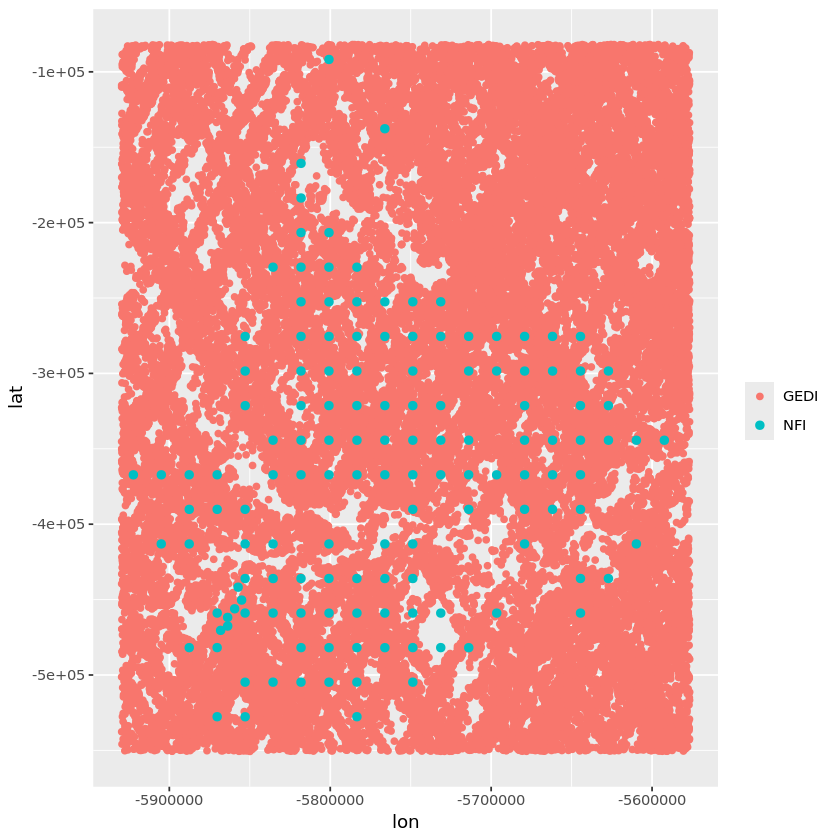

In [59]:
factor <- (1/1)

gedi_coords <- as.data.frame(gedi %>% st_coordinates())
nfi_coords <- as.data.frame(nfi %>% st_coordinates())
loc_gedi = data.matrix(as.data.frame(cbind(gedi_coords$X,gedi_coords$Y)))
loc_nfi = data.matrix(as.data.frame(cbind(nfi_coords$X,nfi_coords$Y)))

ggplot() + geom_point(aes(x = loc_gedi[,1], y = loc_gedi[,2], col = "GEDI")) +
  geom_point(aes(x = loc_nfi[,1], y = loc_nfi[,2], col = "NFI"), size = 2) +
  xlab("lon") + ylab("lat") + labs(col = "")

gedi_nfi <- gedi %>% st_drop_geometry()
nfi_nfi <- nfi %>% st_drop_geometry()

gedi <- (gedi$agbd)
nfi <- (nfi$AGB_Mg.ha2)

In [60]:
factor <- (3)
nfi <- (nfi)^factor

[1] 6408

[1] 1525

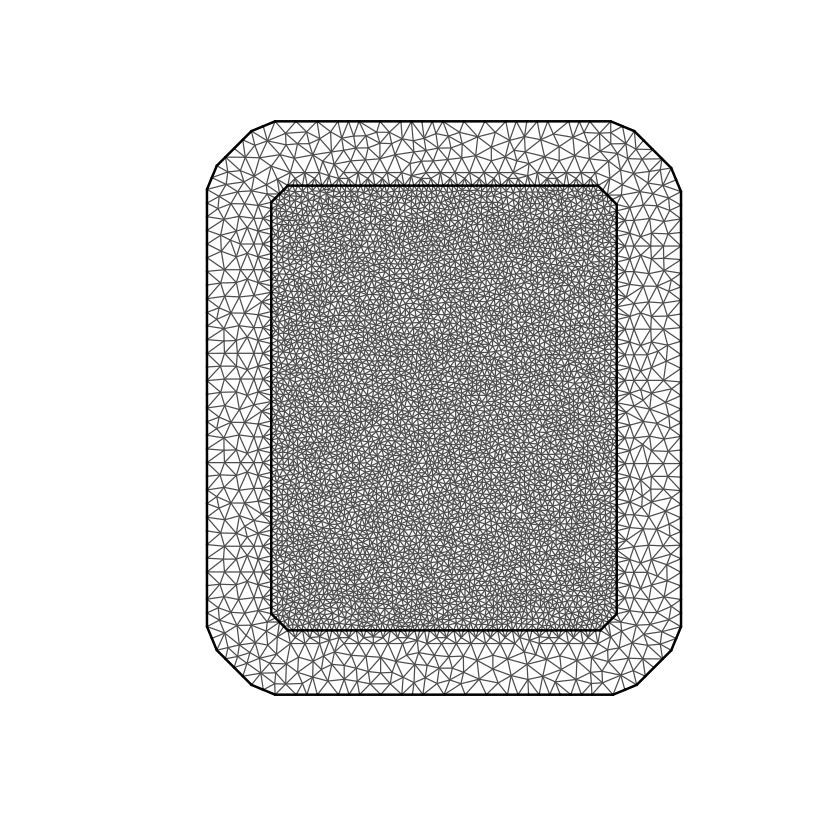

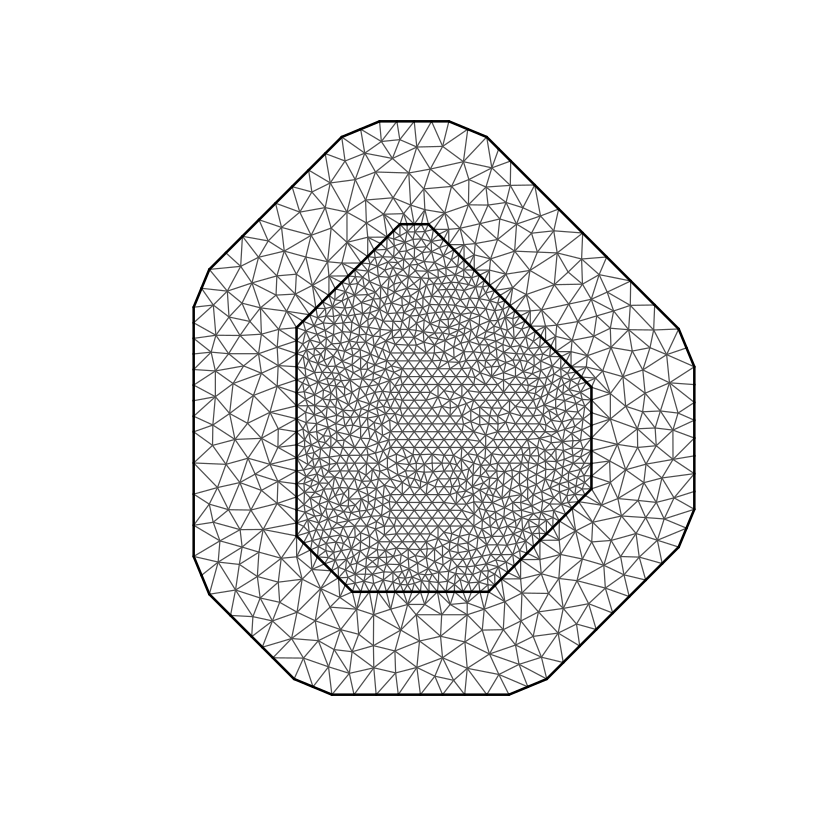

In [63]:
# sigma1 = 1
range1 = 25000
# theta1 = reg2theta(c(sigma1, range1)) # INLA's internal parametrization
# tau1 = 0.5

# sigma2 = sqrt(0.25)
range2 = 50000
# theta2 = reg2theta(c(sigma2, range2)) # INLA's internal parametrization
# tau2 = 0.1

# beta = sqrt(0.75)
# intercept_gedi = 3
# intercept_nfi = 4

mesh1 = inla.mesh.2d(loc = loc_gedi, 
                     max.edge = c(range1/5, range1),
                     cutoff = c(range1/5),
                     offset = c(range1, 3*range1))
mesh1$n  
plot(mesh1)

mesh2 = inla.mesh.2d(loc = loc_nfi, 
                     max.edge = c(range2/5, range2),
                     cutoff = c(range2/5),
                     offset = c(range2, 3*range2))
mesh2$n  
plot(mesh2)


# # Sim Gaussian fields and data

spde1 = inla.spde2.matern(mesh1)
spde2 = inla.spde2.matern(mesh2)

# Q1 = inla.spde2.precision(spde1, theta1)
# w1 = inla.qsample(Q = Q1)

# Q2 = inla.spde2.precision(spde2, theta2)
# w2 = inla.qsample(Q = Q2)

A1_gedi = inla.spde.make.A(mesh1, loc_gedi)
A1_nfi = inla.spde.make.A(mesh1, loc_nfi)
A2_nfi = inla.spde.make.A(mesh2, loc_nfi)

# # # gedi = drop(intercept_gedi + A1_gedi%*%w1 + rnorm(n_gedi, sd = tau1) )

# ggplot() + geom_point(aes(x = loc_gedi[,1], y = loc_gedi[,2], col = gedi))  +
#   scale_color_viridis(limits = quantile(gedi, c(0.01, 0.99)), oob = scales::squish) +
#   xlab("lon") + ylab("lat")  + theme_dark()

# # # nfi = drop(intercept_nfi + beta*A1_nfi%*%w1 + A2_nfi%*%w2 + rnorm(n_nfi, sd = tau2))

# ggplot() + geom_point(aes(x = loc_nfi[,1], y = loc_nfi[,2], col = nfi)) +
#   scale_color_viridis(limits = quantile(nfi, c(0.01, 0.99)), oob = scales::squish) +
#   xlab("lon") + ylab("lat") + theme_dark()

In [65]:
######################################################
######################################################
# Fit coregionalization model
######################################################
######################################################

n_gedi = length(gedi)
n_nfi = length(nfi)

# Constructing the stacks and formula for coreg models is the weirdest bit.
# I'll try to explain it as I go.

# Make the gedi stack
stack_gedi = inla.stack(
  data = list(y = cbind(gedi, NA)), # Notice a leave a column open for the NFI observations...
  A = list(1, A1_gedi), # And my A's and effects only include things that are in the gedi equation.
  effects = list(int_gedi = rep(1,n_gedi), w1 = 1:mesh1$n)
)

# Make the nfi stack
stack_nfi = inla.stack(
  data = list(y = cbind(NA, nfi)), # See how the empty slot is swapped?
  A = list(1, A1_nfi, A2_nfi), # Again, only things in the nfi equation.
  effects = list(int_nfi = rep(1,n_nfi), w12 = 1:mesh1$n, w2 = 1:mesh2$n) # w12 is the 'copy' of w1 in the gedi equation, but it needs a unique name. We'll tell INLA it's a copy in the formula lower down.
)

stack_full = inla.stack(stack_gedi, stack_nfi) # Merge 'em.

# Create SPDE objects with PC priors.
spde1 = inla.spde2.pcmatern(
  mesh = mesh1,
  prior.range = c(25000, 0.01), 
  prior.sigma = c(60, 0.01))

spde2 = inla.spde2.pcmatern(
  mesh = mesh2,
  prior.range = c(25000, 0.01), 
  prior.sigma = c(60, 0.01))

# Our normal prior on the beta coefficient. It's a mean and precision parameterization (precision of 2 implies a SD of sqrt(1/2)).
beta_prior <- list(beta = list(prior = 'normal', param = c(1, 2)))

# Last weird bit. You need to list all terms in the equation. INLA will know which go to gedi and the nfi from your individual stacks.

form = y ~ -1 + int_gedi + 
  int_nfi + 
  f(w1, model = spde1) + 
  f(w12, copy = 'w1', fixed = FALSE, hyper = beta_prior) + # This is how we tell INLA w12 is a copy of w1. The 'fixed = FALSE' tells INLA it needs to estimate \beta, rather than fix it at some provided value (default is 1, I think?)
  f(w2, model = spde2)


# Let 'er rip.
coreg_mod = inla(form, rep('gaussian', 2), # The rep('gaussian', 2) tells INLA that both gedi and nfi are assumed to be gaussian.
               data = inla.stack.data(stack_full), 
               control.predictor = list(A = inla.stack.A(stack_full)),
               control.compute = list(config = T, dic = T, waic = T, cpo = T),
               verbose = T)

summary(coreg_mod)
hist(coreg_mod$cpo$pit, breaks = 20) 


 *** inla.core.safe:  The inla program failed, but will rerun in case better initial values may help. try=1/1 


ERROR: Error in inla.core.safe(formula = formula, family = family, contrasts = contrasts, : The inla-program exited with an error. Unless you interupted it yourself, please rerun with verbose=TRUE and check the output carefully.
  If this does not help, please contact the developers at <help@r-inla.org>.
The inla program failed and the maximum number of tries has been reached.


In [ ]:
#####################
# Predict nfi on a regular grid.
# Hopefully this stuff makes sense from your previous work.
#########################

grid_to_predict = st_make_grid(AOI, cellsize = c(5000,5000), what = "centers") %>% st_as_sf()
grid = as.data.frame(grid_to_predict %>% st_coordinates())
loc.plot_T <- data.matrix(as.data.frame(cbind(grid$X,grid$Y)))

n_pred = nrow(loc.plot_T)

A1_pred = inla.spde.make.A(mesh1, loc.plot_T)
A2_pred = inla.spde.make.A(mesh2, loc.plot_T)

nsamps = 250

sample = inla.posterior.sample(n = nsamps, coreg_mod)

coreg_mod$mode$theta # Super janky, but I used this to find out INLA is storing beta in theta[7] and the precision of \epsilon_nfi(s) in theta[2]. I use this info in the prediction function below.

pred_fun = function(...){
  drop(int_nfi + theta[7]*A1_pred%*%w1 + A2_pred%*%w2 + rnorm(n_pred, sd = sqrt(1/theta[2])))
  }

pred.samples = inla.posterior.sample.eval(pred_fun, sample, )


pred_mu = Matrix::rowMeans(pred.samples,na.rm=TRUE)
pred_sd = apply(pred.samples, 1, sd)

ggplot() + geom_raster(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], fill = pred_mu)) +
  scale_fill_viridis(limits = quantile(pred_mu, c(0.01, 0.99)), oob = scales::squish) +
  xlab("lon") + ylab("lat")  + theme_dark()

ggplot() + geom_raster(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], fill = pred_sd)) +
  scale_fill_viridis(option = "turbo", limits = quantile(pred_sd, c(0.01, 0.99)), oob = scales::squish) +
  xlab("lon") + ylab("lat")  + theme_dark()